In [16]:
import os, sys, glob, time, datetime
import natsort
import cv2
import numpy as np
import torch
import torchvision.models.segmentation
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

# TODO
# -change train to train epoch
# -add IoU per epoch
# -add validation per epoch

In [17]:
learning_rate=1e-5
width=400
height=300# image width and height
batchSize=8

def imgFolder(mode): return os.path.join("../FloodNet-Supervised_v1.0_resized/", mode , mode + "-org-img")
def maskFolder(mode): return os.path.join("../FloodNet-Supervised_v1.0_resized/", mode , mode + "-label-img")
predFolder = "./predicted_masks"
modelFolder = "./runs"
dir_summary = "./runs"

In [18]:
#Image transforms
transformImg = tf.Compose([
    tf.ToPILImage(), 
    tf.Resize((height, width)), 
    tf.ToTensor(),
    tf.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
# Messes up the pixel values by scaling them!!!
# transformMask = tf.Compose([
#     tf.ToPILImage(),
#     tf.Resize((height,width), tf.InterpolationMode.NEAREST),
#     tf.ToTensor()
# ])

In [19]:
def normtensor2mask(tensor):
    scaled_tensor = tensor * 255.0
    rounded_tensor = torch.round(scaled_tensor)
    return rounded_tensor

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
#Download the pretrained backbone
Net = torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT') # Load net

In [22]:
total_layers = len(list(Net.parameters()))
print(f"Total number of layers in the model: {total_layers}")

Total number of layers in the model: 187


In [23]:
for name, module in Net.named_children():
    print(f"Module: {name}")
    #print(module)
    print("=" * 50)

Module: backbone
Module: classifier
Module: aux_classifier


In [24]:
#Freeze all parameters
for param in Net.parameters():
    param.requires_grad = False
#Unfreeze last layer of auxilary classifier
for param in Net.aux_classifier[4].parameters():
    param.requires_grad = True
#Unfreeze all classifier layer
for param in Net.classifier.parameters():
    param.requires_grad = True 

In [25]:
# for name, param in Net.named_parameters():
#     print(f"Layer: {name}, Requires Grad: {param.requires_grad}")

In [26]:
#Edit last layer to fit the images and number of classess
Net.classifier[4] = torch.nn.Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
Net.aux_classifier[4] = torch.nn.Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
Net = Net.to(device)


In [27]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, mode, transform_img):
        self.mode = mode
        self.list_images = natsort.natsorted(os.listdir(imgFolder(self.mode)))
        self.transform_img = transform_img

    def __len__(self):
        return len(self.list_images)

    def get_list_names(self):
        return self.list_images

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(imgFolder(self.mode), self.list_images[idx]))
        mask = cv2.imread(os.path.join(maskFolder(self.mode), self.list_images[idx].replace(".jpg", "_lab.png")), 0)
        img = self.transform_img(img)
        mask = torch.from_numpy(mask)

        return img, mask


In [28]:
train_dataset = CustomDataset(mode='train', transform_img=transformImg)
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True)

In [29]:
def train(net, num_epochs, learning_rate, train_loader, writer):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        net.train()

        current_time = time.time()
        previous_time = time.time()
        avg_step_time = 0

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            previous_time = current_time
            current_time = time.time()
            step_time = current_time - previous_time
            avg_step_time = avg_step_time + (step_time - avg_step_time) / (i+1)

            optimizer.zero_grad()
            outputs = net(images)['out']
            loss = criterion(outputs, masks.long())
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            print(f'\rEpoch {epoch} [{i+1}/{len(train_loader)}]: Loss={loss.item():.4f} avgStep={avg_step_time:.2f}s', end='')

            if i%10==0:
                writer.add_scalar('loss', loss.item(), i + len(train_loader) * epoch)

        if epoch % 10 == 0:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            print("\nSaving model " + f"epoch{str(epoch)}_model_{timestamp}.torch")
            torch.save(net.state_dict(), f"{modelFolder}/epoch{str(epoch)}_model_{timestamp}.torch")

        print(f'\nEpoch {epoch} Loss: {epoch_loss / len(train_loader):.2f} avgStep: {avg_step_time:.2f}')
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    print("\nSaving final model " + f"model_{timestamp}.torch")
    torch.save(net.state_dict(), f"{modelFolder}/model_{timestamp}.torch")

In [44]:
writer = SummaryWriter(dir_summary)

try:
    train(Net, 100, learning_rate, train_loader=train_loader, writer=writer)
except KeyboardInterrupt:
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(Net.state_dict(), f"{modelFolder}/INTERRUPTED_model_{timestamp}.torch")
    print('\nSaved interrupt')
finally:
    writer.close()

Epoch 0 [181/181]: Loss=1.3236 avgStep=0.53s
Saving model epoch0_model_20231112_210036.torch

Epoch 0 Loss: 1.35 avgStep: 0.53
Epoch 1 [181/181]: Loss=1.3753 avgStep=0.55s
Epoch 1 Loss: 1.19 avgStep: 0.55
Epoch 2 [181/181]: Loss=1.1215 avgStep=0.57s
Epoch 2 Loss: 1.06 avgStep: 0.57
Epoch 3 [181/181]: Loss=1.0914 avgStep=0.59s
Epoch 3 Loss: 0.99 avgStep: 0.59
Epoch 4 [181/181]: Loss=1.0017 avgStep=0.60s
Epoch 4 Loss: 0.91 avgStep: 0.60
Epoch 5 [181/181]: Loss=1.0390 avgStep=0.60s
Epoch 5 Loss: 0.86 avgStep: 0.60
Epoch 6 [181/181]: Loss=0.7029 avgStep=0.61s
Epoch 6 Loss: 0.81 avgStep: 0.61
Epoch 7 [181/181]: Loss=0.5860 avgStep=0.61s
Epoch 7 Loss: 0.76 avgStep: 0.61
Epoch 8 [181/181]: Loss=0.7484 avgStep=0.61s
Epoch 8 Loss: 0.72 avgStep: 0.61
Epoch 9 [181/181]: Loss=0.6821 avgStep=0.61s
Epoch 9 Loss: 0.69 avgStep: 0.61
Epoch 10 [181/181]: Loss=0.6222 avgStep=0.61s
Saving model epoch10_model_20231112_211839.torch

Epoch 10 Loss: 0.66 avgStep: 0.61
Epoch 11 [181/181]: Loss=0.7661 avgStep=0

In [45]:
LABEL_TO_COLOR = {
    0: [0, 0, 0],     # Black (background)
    1: [255, 0, 0],   # Red (building-flooded)
    2: [190, 100, 100],  # Brown (building-non-flooded)
    3: [107, 142, 35], # Dirty Green (road-flooded)
    4: [200, 200, 200],# Grey (road-non-flooded)
    5: [0, 255, 255],  # Cyan (water)
    6: [0, 0, 255],    # Blue (tree)
    7: [255, 0, 255],  # Magenta (vehicle)
    8: [255, 255, 0],  # Yellow (pool)
    9: [0, 255, 0],    # Green (grass)
}

def mask2rgb(mask):
    rgb = np.zeros(mask.shape + (3,), dtype=np.uint8)
    
    for label, color in LABEL_TO_COLOR.items():
        rgb[mask == label] = color
    
    return rgb

def rgb2mask(rgb):
    mask = np.zeros(rgb.shape[:2], dtype=np.uint8)

    for label, color in LABEL_TO_COLOR.items():
        mask[np.all(rgb == color, axis=2)] = label
        
    return mask


def get_train_dataset(mode='train', sl=slice(None)): 
    images = []
    true_mask = []
    
    list_images = natsort.natsorted(os.listdir(imgFolder(mode)))[sl]
    for idx in range(len(list_images)):
        img = cv2.imread(os.path.join(imgFolder(mode), list_images[idx]))
        mask = cv2.imread(os.path.join(maskFolder(mode), list_images[idx].replace(".jpg", "_lab.png")), 0)

        images.append(img)
        true_mask.append(mask2rgb(mask))
        
    return images, true_mask


def get_eval_datasets(mode='val', resize=True):
    images = []
    true_mask = []
    pred_mask = []
    
    list_images = natsort.natsorted(os.listdir(predFolder))
    for idx in range(len(list_images)):
        pred = cv2.imread(os.path.join(predFolder, list_images[idx]))
        pred_mask.append(pred)
    
    images, true_mask = get_train_dataset(mode=mode, sl=slice(None,len(pred_mask)))

    if resize:
        for i in range(len(images)):
            new_size = images[i].shape[:2][::-1]
            pred_mask[i] = cv2.resize(pred_mask[i], new_size)

    return images, true_mask, pred_mask


In [46]:
def get_latest_model(modelPath=modelFolder):
    model_files = glob.glob(os.path.join(modelPath, "*model_*.torch"))
    # Sort the files based on their modification time (timestamp)
    latest_model = max(model_files, key=os.path.getmtime)
    return latest_model

In [47]:
test_dataset = CustomDataset(mode='val', transform_img=transformImg)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False, num_workers=0, pin_memory=True)

In [48]:
def eval(net, test_loader, testing=False):
    net.load_state_dict(torch.load(get_latest_model(modelFolder)))
    net.eval()
    
    os.makedirs("predicted_masks", exist_ok=True)
    if testing: os.makedirs("imgs", exist_ok=True)
    
    for i, (images, ann) in enumerate(test_loader):
        if testing and i >= 2:
            print(f"\nEarly stop at epoch 2")
            break
        # org_imgs, org_masks = get_train_dataset(mode='val', slice=slice(batchSize*i, batchSize*(i+1)))
        images = images.to(device)
    
        with torch.no_grad():
            pred = net(images)['out']
        pred = torch.argmax(pred, 1).cpu().detach().numpy()
    
        for j in range(pred.shape[0]):
            # new_size = org_imgs[j].shape[:2][::-1]
            # pred[j] = cv2.resize(pred[j], new_size)
            pred_mask = Image.fromarray(mask2rgb(pred[j]))
            pred_mask.save(os.path.join(predFolder, f"pred_mask_{j+batchSize*i}.png"))
            if testing:
                image_array = (images[j].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
                img = Image.fromarray(image_array)
                img.save(os.path.join("imgs", f"img_{j+batchSize*i}.png"))
        
        # pred_mask = pred.tolist()
        # true_mask_flat = [mask.flatten() for mask in org_masks]
        # pred_mask_flat = [mask.flatten() for mask in pred_mask]
          
        # iou_per_class = jaccard_score(np.concatenate(true_mask_flat), np.concatenate(pred_mask_flat), average=None)
        # miou = np.mean(iou_per_class)
        # print(f"Batch {i}  Class 0: {iou_per_class[0]:.4f} Class 1: {iou_per_class[1]:.4f} Class 2: {iou_per_class[2]:.4f} Mean IoU: {miou:.4f}")
    
        print(f'\rBatch {i+1}/{len(test_loader)} processed.', end='')

In [49]:
def eval_stats(testing=False):
    print("\rloading datasets...", end='')
    images, true_mask, pred_mask = get_eval_datasets(mode='val', resize = not testing)
    print("\rdatasets loaded!", end='')

    if testing:
        imgs = []
        list_images = natsort.natsorted(os.listdir("imgs"))
        for idx in range(len(list_images)):
            img = cv2.imread(os.path.join('imgs', list_images[idx]))
            imgs.append(img)
    
    num_cols = 4 if testing else 3
    num_rows = len(pred_mask[:5])
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))
    for i in range(num_rows):
        # Display the original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('on')
        axes[i, 0].set_title('Original Image')
    
        # Display the true mask
        axes[i, 1].imshow(true_mask[i], cmap='gray')
        axes[i, 1].axis('on')
        axes[i, 1].set_title('True Mask')
    
        # Display the predicted mask
        axes[i, 2].imshow(pred_mask[i], cmap='gray')
        axes[i, 2].axis('on')
        axes[i, 2].set_title('Predicted Mask')
        
        if testing:
            axes[i, 3].imshow(imgs[i], cmap='gray')
            axes[i, 3].axis('on')
            axes[i, 3].set_title('Predicted Mask')
    
    plt.tight_layout()
    plt.show()
    
    if not testing:
        print("\rcalculating stats...", end='')
        true_mask_flat = [mask.flatten() for mask in true_mask]
        pred_mask_flat = [mask.flatten() for mask in pred_mask]
               
        iou_per_class = jaccard_score(np.concatenate(true_mask_flat), np.concatenate(pred_mask_flat), average=None)
        
        miou = np.mean(iou_per_class)
        
        print("Jaccard Index (IoU) per class:")
        for class_idx, iou in enumerate(iou_per_class):
            print(f"Class {class_idx}: {iou:.4f}")
        
        print("Mean IoU (mIoU):", miou)

In [50]:
testing=False

In [51]:
try:
    eval(Net, test_loader=test_loader, testing=testing)
except KeyboardInterrupt:
    print('Eval interrupted!')

Batch 57/57 processed.

datasets loaded!...

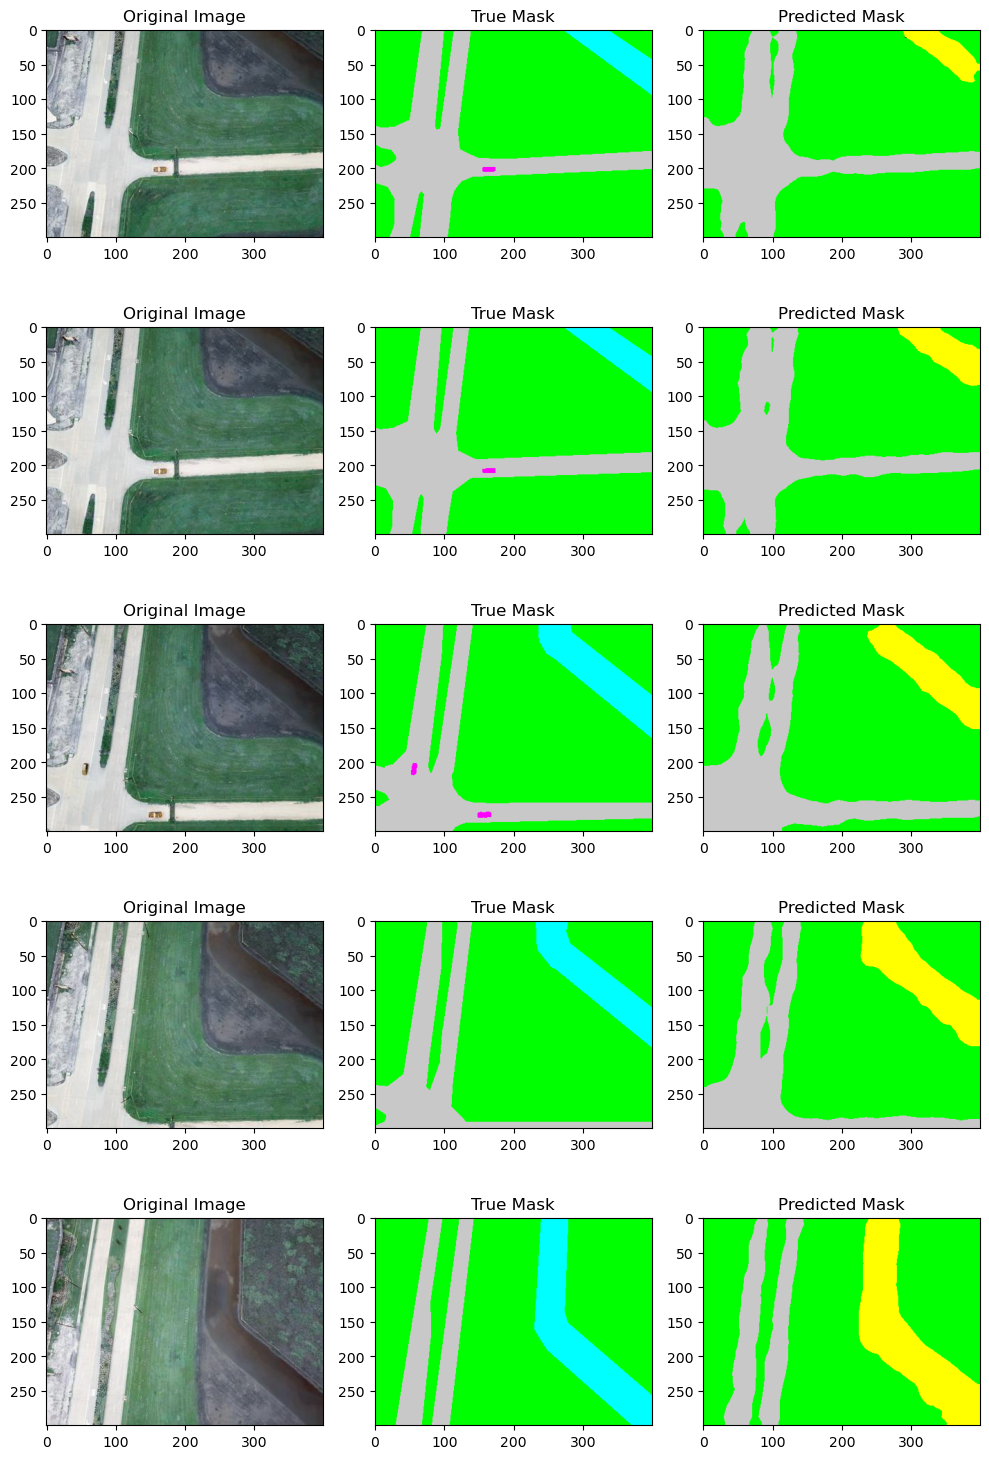

calculating stats...Jaccard Index (IoU) per class:
Class 0: 0.6236
Class 1: 0.0000
Class 2: 0.2341
Class 3: 0.0000
Class 4: 0.4397
Class 5: 0.0000
Class 6: 0.6668
Class 7: 0.4520
Mean IoU (mIoU): 0.30202743303908053


In [52]:
eval_stats(testing=testing)

In [95]:
def calculate_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_iou_for_all_pairs(true_masks, pred_masks):
    iou_list = []

    for true_mask, pred_mask in zip(true_masks, pred_masks):
        iou = calculate_iou(true_mask, pred_mask)
        iou_list.append(iou)

    return iou_list


images, true_masks, pred_masks = get_eval_datasets(mode='val')
iou_list = calculate_iou_for_all_pairs(true_masks, pred_masks)

In [175]:
ranking = sorted(zip(images, true_masks, pred_masks, iou_list), key=lambda x: x[3], reverse=True)
top_3 = ranking[:3]
bottom_3 = ranking[-3:]

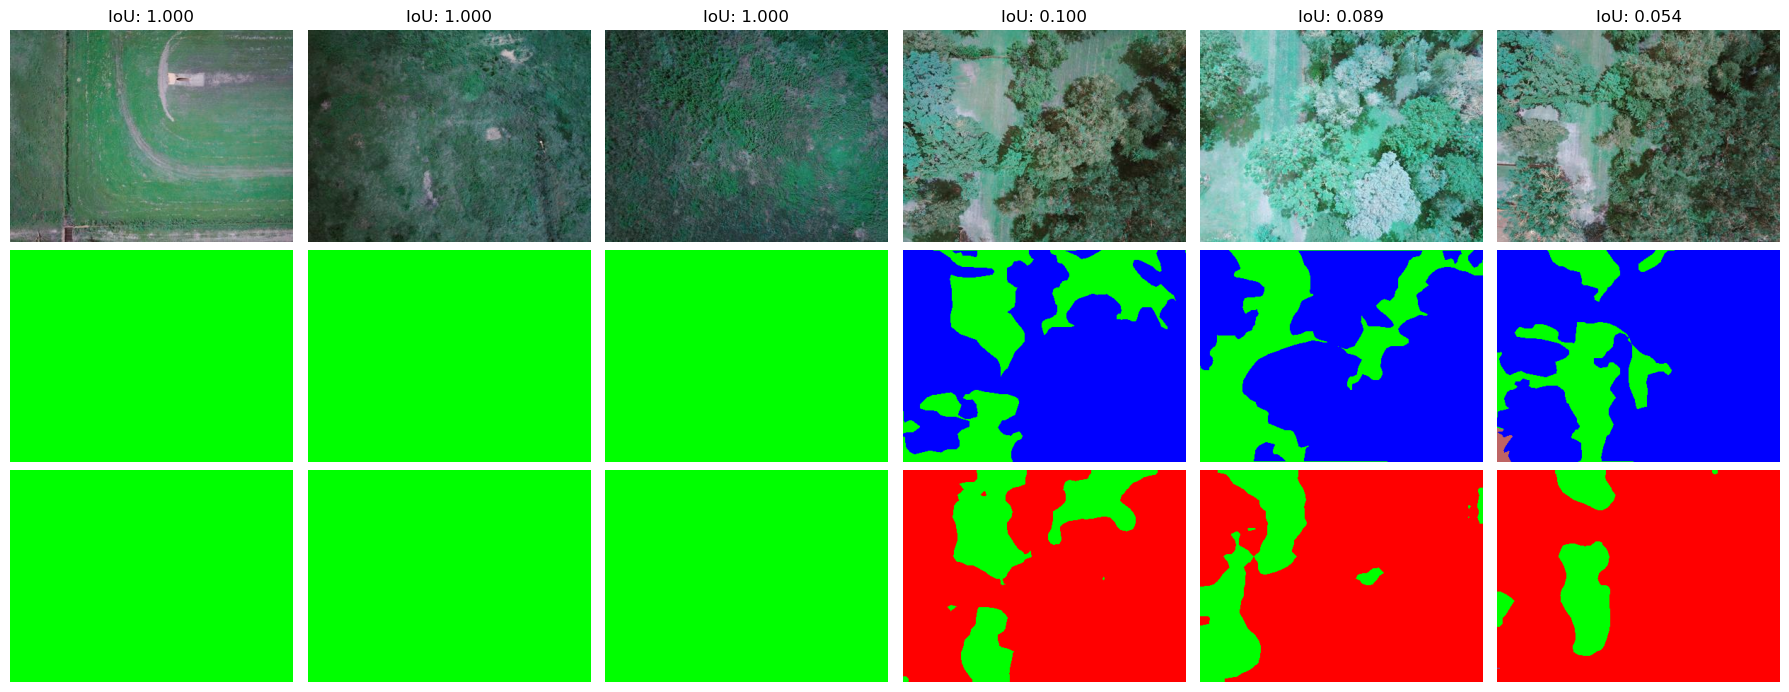

In [176]:
plt.figure(figsize=(18, 7))

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 1)
    plt.imshow(image)
    plt.title(f'IoU: {iou:.3f}')
    plt.axis('off')

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 7)
    plt.imshow(true_mask)
    plt.axis('off')

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 13)
    plt.imshow(pred_mask)
    plt.axis('off')

#plt.subplots_adjust(hspace=0.01)
plt.tight_layout()
plt.show()


In [177]:
def calculate_percentage_for_dominant_class(mask):
    # Function to calculate the percentage of pixels for the dominant class
    
    unique_classes, class_counts = np.unique(mask, return_counts=True)
    dominant_class_count = np.max(class_counts)
    total_pixels = mask.size
    percentage = (dominant_class_count / total_pixels) * 100
    return percentage

# Filtering out positions with true_masks with more than 70% of pixels in any single class
filtered_ranking = [
    (image, true_mask, pred_mask, iou)
    for image, true_mask, pred_mask, iou in zip(images, true_masks, pred_masks, iou_list)
    if calculate_percentage_for_dominant_class(rgb2mask(true_mask)) < 50
]
ranking = sorted(filtered_ranking, key=lambda x: x[3], reverse=True)
top_3 = ranking[:3]
bottom_3 = ranking[-3:]

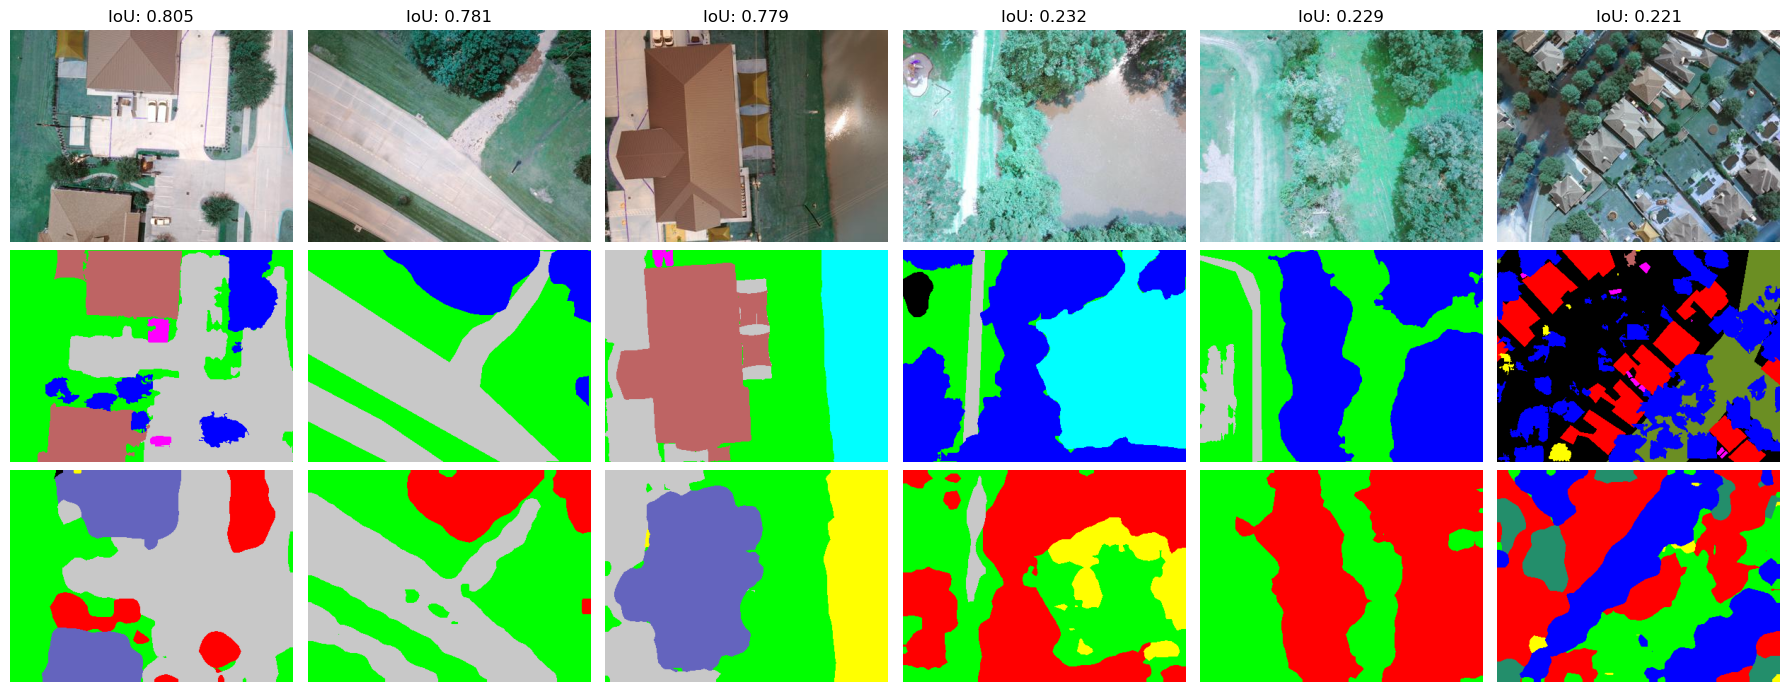

In [178]:
plt.figure(figsize=(18, 7))

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 1)
    plt.imshow(image)
    plt.title(f'IoU: {iou:.3f}')
    plt.axis('off')

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 7)
    plt.imshow(true_mask)
    plt.axis('off')

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 13)
    plt.imshow(pred_mask)
    plt.axis('off')

#plt.subplots_adjust(hspace=0.01)
plt.tight_layout()
plt.show()
